# Image Augmentation examples 

---------------
```
이번 차종 이미지 분류 대회는 train set 이미지가 10,000개, 차종 class가 196개로 class당 대략 51개 정도의 이미지를 가지고 있습니다. 매우 작은 양의 이미지로 학습되기 때문에 과대적합을 피하고 일반화된 성능을 끌어내기 위해서는 Image Augmentation(이미지 증식)은 필수조건입니다.
keras에는 Image Augmentation을 위한 ImageDataGenerator 함수가 있으며 지금까지 찾아보고 실습한 내용을 정리해서 올립니다. 흔히 사용하는 rotate, shift, zoom, flip 뿐만아니라 조금 더 다양한 노이즈 적용방식을 구현해보고 샘플을 확인해보겠습니다. (기본적인 이미지로딩 과정과 뼈대는 기존 커널들을 참고하였습니다.)

- 커널 참고
    - Daehun Gwak, Keras, How to use pretrained model?
    - Jang, Car Model Classification (Xception)
- Augmentation 함수 관련
    - https://keras.io/preprocessing/image/
    - https://www.kaggle.com/safavieh/image-augmentation-using-skimage
    - https://www.kaggle.com/gaborfodor/augmentation-methods 
    - https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
```
---------------
 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'train', 'train.csv', 'class.csv', 'sample_submission.csv']


In [2]:
import warnings
import matplotlib.pylab as plt
import PIL
warnings.filterwarnings('ignore')
image_size = 224

In [3]:
# 이미지 폴더 경로
DATA_PATH = '../input/'
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_train = df_train.iloc[:50] # 편의상 50개까지만 이용 
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [4]:
def crop_boxing_img(img_name, margin=16, size=(image_size, image_size)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

In [5]:
TRAIN_CROP_PATH = "./train_crop"
!mkdir {TRAIN_CROP_PATH}

In [6]:
# train_set의 모든 이미지에 대해 적용할 경우 시간이 좀 걸립니다.
for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(f"{TRAIN_CROP_PATH}/{row['img_file']}")

In [7]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')
df_train = df_train[['img_file', 'class']]

X_val = df_train.copy()
# its = np.arange(df_train.shape[0])
# train_idx, val_idx = train_test_split(its, test_size = 0.8, shuffle= False)
# X_train = df_train.iloc[train_idx, :]
# X_val = df_train.iloc[val_idx, :]

# print(X_train.shape)
print(X_val.shape)

(50, 2)


In [8]:
import keras 
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


```
먼저 rotaion, shift, zoom, flip에 대한 변형을 실행해보겠습니다. 
각 인자들에 대한 상세한 내용은 아래 사이트에서 살펴보시면 됩니다.
https://keras.io/preprocessing/image/ 

그리고 중요한 사항으로 rescaled을 이용하여 이미지의 행렬값을 0~255에서 0~1로 변경하는 부분입니다. 신경망모델에서는 데이터의 특성에 대해서 스케일링한다음 학습하는 것이 매우 중요합니다.
```

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255) 

In [10]:
img_size = (image_size, image_size)
batch_size = 10

train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =False
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_CROP_PATH,
    x_col ='img_file',
    y_col ='class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =False
)

Found 50 validated image filenames belonging to 46 classes.
Found 50 validated image filenames belonging to 46 classes.


In [11]:
# 아래와 같이 augmentation 처리된 이미지들을 확인할 수 있습니다.

for data1, label1 in train_generator:
    print('배치 데이터 크기:', data1.shape)
    print('배치 레이블 크기:', label1.shape)
    break
    
for data2, label2 in validation_generator:
    print('배치 데이터 크기:', data2.shape)
    print('배치 레이블 크기:', label2.shape)
    break    

       

배치 데이터 크기: (10, 224, 224, 3)
배치 레이블 크기: (10, 46)
배치 데이터 크기: (10, 224, 224, 3)
배치 레이블 크기: (10, 46)


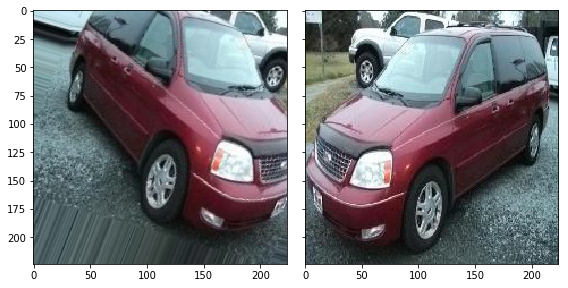

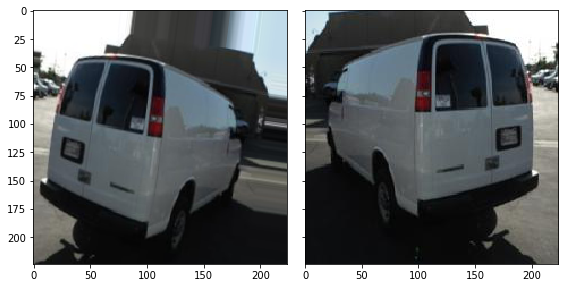

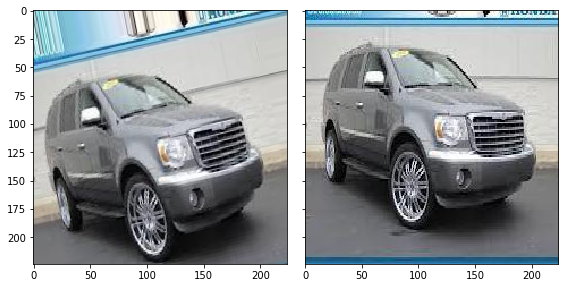

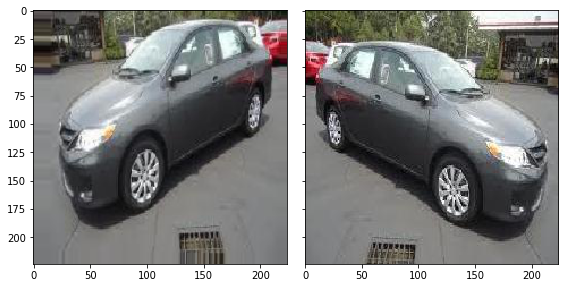

In [12]:
# 왼쪽은 증식된(변형된)이미지, 오른쪽은 기존 이미지입니다.

import matplotlib.pyplot as plt
from keras.preprocessing import image

for i in range(4):   
    fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)
    axs[0].imshow(image.array_to_img(data1[i]))
    axs[1].imshow(image.array_to_img(data2[i]))
    fig.tight_layout()
    plt.show()


```
featurewise_center
samplewise_center
featurewise_std_normalization
samplewise_std_normalization
zca_whitening

해당 인자들을 True로 활성화하려면 train_datagen.fit(train_x)을 해줘야합니다.
하지만 여기서는 flow_from_dataframe을 이용하기때문에 (이미지가 아닌 경로로 접근) 아래 코드와 같이 바로 설정하지는 못합니다. 
preprocessing_function을 이용하여 동일한 효과를 내는 별도의 함수를 만들어 직접 이미지 처리를 할수 밖에 없습니다.
해당 인자들의 효과는 아래 사이트에서 확인바랍니다.
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
```

In [13]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True.
# train_datagen.fit(train_features)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center= True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization= True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    #rotation_range=40, # randomly rotate images in the range (degrees, 0 to 180)
    #zoom_range = 0.2, # Randomly zoom image 
    #shear_range=0.2,
    #width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    #height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True)  # randomly flip images

# train_datagen.fit() # 이 부분에서 실행되지 않는다.

train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =False
)

train_generator.reset()
validation_generator.reset()


Found 50 validated image filenames belonging to 46 classes.


```
별도함수를 구성하고 preprocessing_function를 이용해 노이즈 필터를 적용해보겠습니다.
이미지 처리를 위해 skimage라는 패키지를 이용하였으며 random하게 필터의 설정값을 적용합니다.
아래코드는 https://www.kaggle.com/safavieh/image-augmentation-using-skimage 을 참고하였습니다.
```

In [14]:
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.util import random_noise
import random

def randRange(a, b):
    return np.random.rand() * (b - a) + a

def randomIntensity(im):
    # rescales the intesity of the image to random interval of image intensity distribution
    return rescale_intensity(im,
                             in_range=tuple(np.percentile(im, (randRange(0,10), randRange(90,100)))),
                             out_range=tuple(np.percentile(im, (randRange(0,10), randRange(90,100)))))

def randomGamma(im):
    # Gamma filter for contrast adjustment with random gamma value.
    return adjust_gamma(im, gamma=randRange(1, 2.5))

def randomGaussian(im):
    # Gaussian filter for bluring the image with random variance.
    return gaussian(im, sigma=randRange(0, 5))

def randomNoise(im):
    # random gaussian noise with random variance.
    var = randRange(0.005, 0.01)
    return random_noise(im, var=var)

# 위 4가지 함수를 넣어 random하게 적용시킨다.
def augment(im, Steps= [randomGamma, randomGaussian, randomNoise]):
    
    im /= 255. # 추가    
    i= np.random.randint(3)
    step = Steps[i]
    im = step(im)
    return im


In [15]:
# augment 함수 내부적으로 스케일링을 하기 때문에 rescale을 뺀다.
train_datagen = ImageDataGenerator(preprocessing_function=augment) 
valid_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =False
)

train_generator.reset()
validation_generator.reset()


Found 50 validated image filenames belonging to 46 classes.


In [16]:
for data1, label1 in train_generator:
    print('배치 데이터 크기:', data1.shape)
    print('배치 레이블 크기:', label1.shape)
    break
    
for data2, label2 in validation_generator:
    print('배치 데이터 크기:', data2.shape)
    print('배치 레이블 크기:', label2.shape)
    break    

배치 데이터 크기: (10, 224, 224, 3)
배치 레이블 크기: (10, 46)
배치 데이터 크기: (10, 224, 224, 3)
배치 레이블 크기: (10, 46)


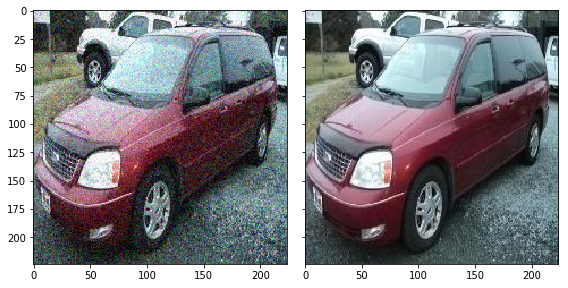

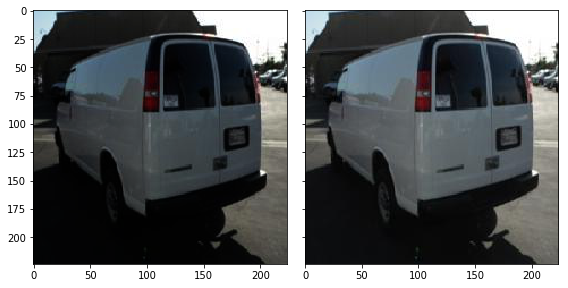

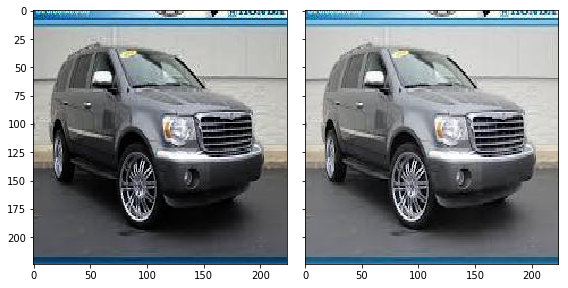

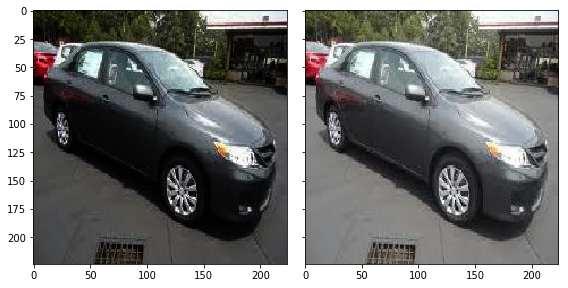

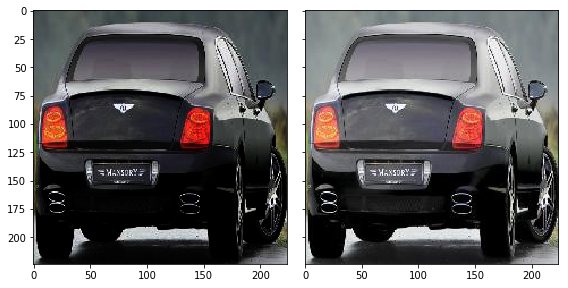

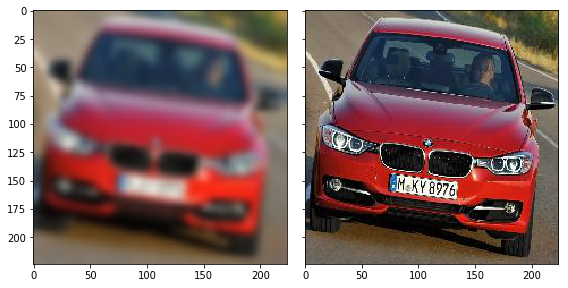

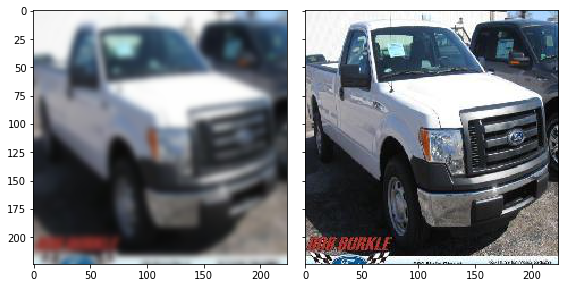

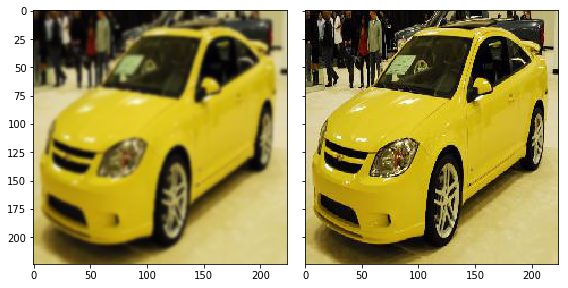

In [17]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

for i in range(8):   
    fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)
    axs[0].imshow(image.array_to_img(data1[i]))
    axs[1].imshow(image.array_to_img(data2[i]))
    fig.tight_layout()
    plt.show()



```
위 사진을 보면 필터값이 너무 세서 아예 뭉개져버린 경우도 발생합니다. 
해당 필터함수내 파라메타값 조정이 필요해보입니다.

커널하나 작성하는것도 시간이 만만치않게 소요되네요.
이미지 색상변경 (color noise) , Fancy PCA 
와 같은 변형기법도 있는데 추후 시간이 되면 업데이트하도록 하겠습니다.
```

In [18]:
!rm -rf *_crop